Based on https://github.com/UNC-optics/Introduction-to-holography/blob/master/Demo_1_Wave_Propagation.m

In [1]:
import numpy as np
from skimage.io import imread, imshow
# from skimage import data
from skimage.transform import resize
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt

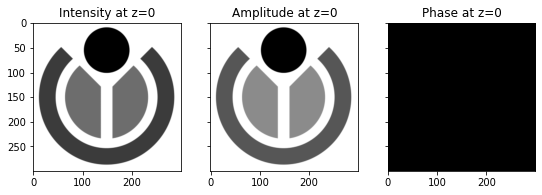

In [5]:
def get_image(x_axis_size, y_axis_size):
    # https://stackoverflow.com/a/52127182/11488517
    url = "https://upload.wikimedia.org/wikipedia/commons/5/53/Wikimedia-logo.png"
    image = imread(url, as_gray=True)
    # image = data.human_mitosis()
    image = resize(image, (x_axis_size, y_axis_size))
    image = image / np.max(image) # normalize
    return image

def show_results(intensity, amplitude, phase, z):
    fig, axs = plt.subplots(1, 3, figsize=(9, 5), sharey=True, sharex=True)
    zstr = str(round(z, 4))
    axs[0].imshow(np.squeeze(intensity), cmap='gray')
    axs[0].set_title('Intensity at z=' + zstr)
    axs[1].imshow(np.squeeze(amplitude), cmap='gray')
    axs[1].set_title('Amplitude at z=' + zstr)
    axs[2].imshow(np.squeeze(phase), cmap='gray')
    axs[2].set_title('Phase at z=' + zstr)


wavelength = 1.0e-6 # meters (1.0 * 10^-6 = 0.0000010) AKA lambda
pixel_size = 10.0e-6 # meters
x_axis_size = 300
y_axis_size = 300

propagation_distances_meters = np.linspace(0, 0.010, 20) # 20 equally spaced numbers between 0.010 and 20 inclusive

# Create millimeter coordinates for the x and y axes
UX = np.arange(1, x_axis_size + 1) # 1..x_axis_size
UX = np.dot(UX, pixel_size) # UX * pixel_size
UX = np.dot(1000, UX - np.mean(UX)) # 1000 * (UX - mean(UX))

UY = np.arange(1, x_axis_size + 1) # 1..y_axis_size
UY = np.dot(UY, pixel_size) # UY * pixel_size
UY = np.dot(1000, UY - np.mean(UY)) # 1000 * (UY - mean(UY))

image = get_image(x_axis_size, y_axis_size)
image = image / np.max(image) # normalize

# Create a complex field by setting amplitude and phase
amplitude = np.sqrt(image)

# select one of the options below for phase
phase = np.zeros((x_axis_size, y_axis_size))
# phase = np.dot(2 * np.pi, np.random.random((x_axis_size, y_axis_size)))

complex_field = amplitude * np.exp(1j * phase) # j = sqrt(-1)

intensity_at_z0 = np.abs(complex_field)**2 # abs(complex_field)^2
amplitude_at_z0 = np.abs(complex_field)
phase_at_z0 = np.angle(complex_field)

show_results(intensity_at_z0, amplitude_at_z0, phase_at_z0, 0)

# Fresnel Diffraction

Fresnel diffraction models how a planar light wave hitting an aperture of arbitrary shape diffuses over a screen placed at a distant $z$ from that aperture.
It takes advantage of the Huygens Principle whereby an aperture can be modelled as a number of point sources each emitting a spherical wave. The intensity of the light hitting any point $(x, y, z)$ on the screen is the sum of the contributions from each of these point sources:
\begin{equation}
A(x, y, z) = \frac{e^{izk}}{iz\lambda}\int\int_{-\infty}^{\infty}A(x^{\prime}, y^{\prime}, z) e^{\frac{ik}{2z}[(x-x^{\prime})^2 + (y - y^{\prime})^2]}dx^{\prime}dy^{\prime}
\end{equation}
where $(x^{\prime}, y^{\prime}, 0)$ is a point on the aperture and $k=\frac{2\pi}{\lambda}$ with $\lambda$ being the wave length.  
The following implementation takes advantage of the observation that the above can be expressed in terms of a [convolution](https://en.wikipedia.org/wiki/Convolution) operation.  
Let $G(x, y, z) = e^{\frac{ik}{2z}(x^2 + y^2)}$, then the Fresnel diffraction may be rewritten as:
\begin{equation}
A(x, y, z) = \frac{e^{izk}}{iz\lambda} (A*G)(x, y, z)
\end{equation}
The convolution operation $*$ can be turned into a multiplication by applying the [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem) and switching from the spatial domain to the frequency domain through the application of a *Fourier Transform* $\mathcal{F}$ on both $A$ and $G$. Therefore the final expression becomes:
\begin{equation}
A(x, y, z) = \frac{e^{izk}}{iz\lambda} \mathcal{F}^{-1}(\mathcal{F}(A)\cdot\mathcal{F}(G))
\end{equation}
where $\mathcal{F}^{-1}$ is the $inverse$ Fourier Transform required in order to get back to the spatial domain.  
Note that after fully computing the inverse transform, the denominator $iz\lambda$ cancels out leaving only the pure $phase$ term $e^{izk}$ which can be disregarded if all we care about is the field value (i.e. the amplitudes).


In [6]:
def fresnelDiffraction( amplitudes, wavelength, z, psx, psy ):

    M, N = amplitudes.shape

    UY = np.arange( M )
    UY = UY - np.mean( UY )

    UY -= 1 if M%2 == 1 else .5

    UX = np.arange( N )
    UX = UX - np.mean( UX )

    UX -= 1 if N%2 == 1 else .5

    x, y = np.meshgrid( UX, UY )
    
    # in a discrete fourier transform setting
    # the following are the fractional angles 
    # in the complex circle representing each frequency
    kx = x / psx / N 
    ky = y / psy / M 

    H = np.exp( -1j * np.pi * wavelength * z * ( kx**2 + ky**2 ) )

    H = np.fft.fftshift( H )

    objFT = np.fft.fft2( amplitudes )

    field = np.fft.ifft2( objFT * H )

    return field

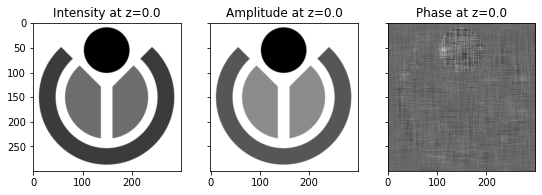

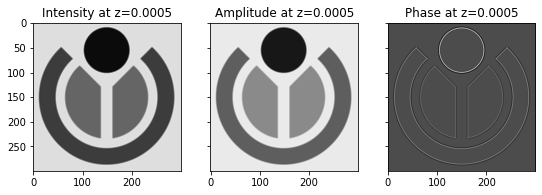

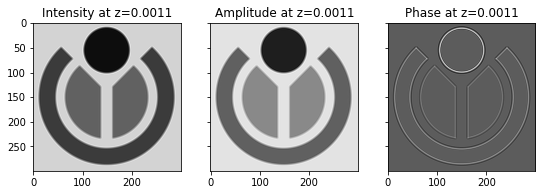

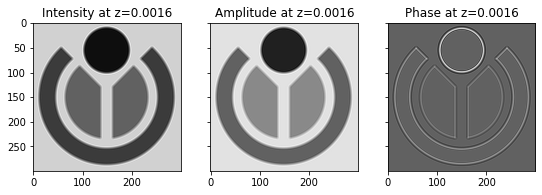

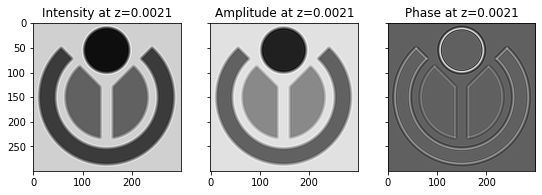

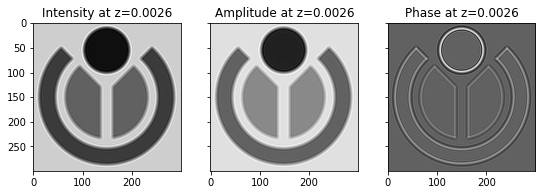

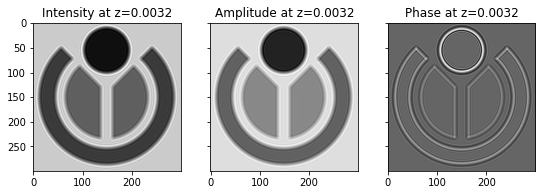

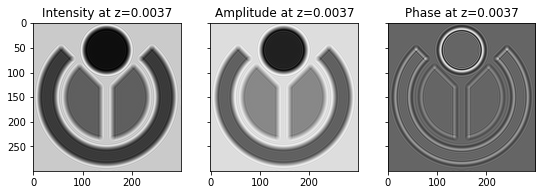

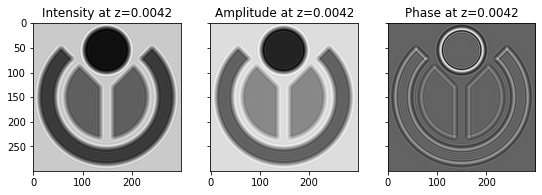

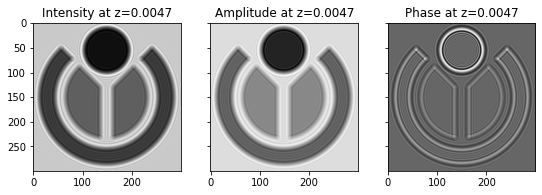

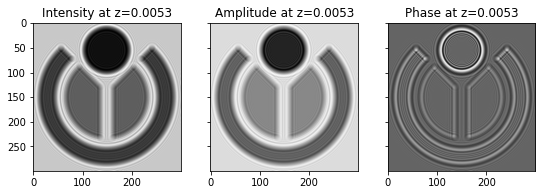

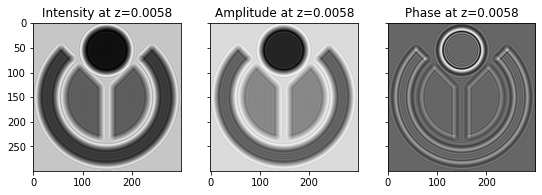

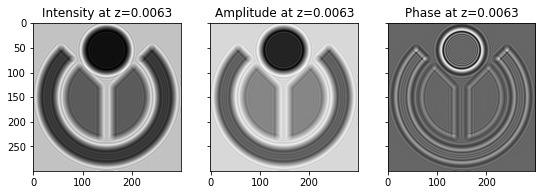

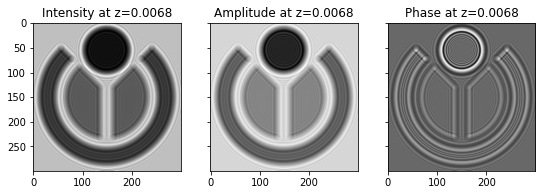

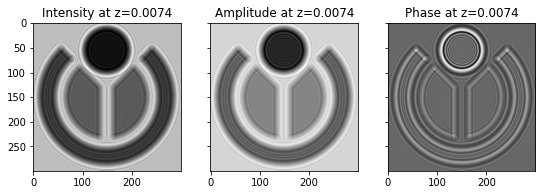

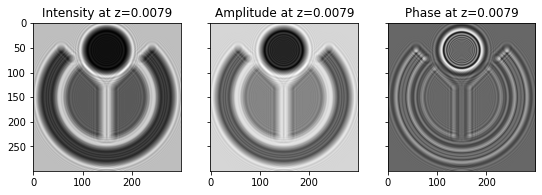

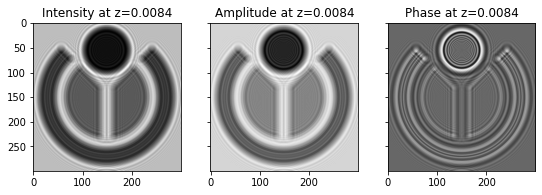

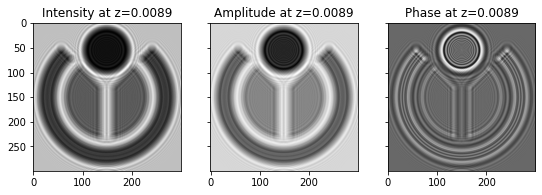

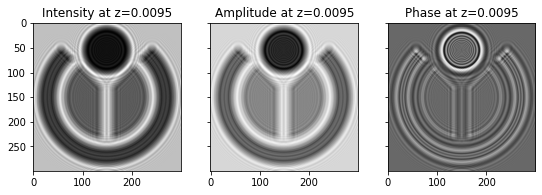

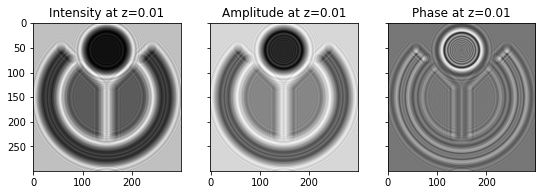

In [7]:
for i in range(propagation_distances_meters.size):
    # Propagate the field
    propagation_distance_meters = propagation_distances_meters[i]
    new_field = fresnelDiffraction(complex_field, wavelength, propagation_distance_meters, pixel_size, pixel_size)

    intensity_at_z = np.abs(new_field)**2
    amplitude_at_z = np.abs(new_field)
    phase_at_z = np.angle(new_field)

    show_results(intensity_at_z, amplitude_at_z, phase_at_z, propagation_distance_meters)